In [1]:
import warnings
import pandas as pd
from tqdm import tqdm

from helpers import classification as pf
from helpers import stats as bf
from helpers.file import save_file

from services import MySQLService

warnings.filterwarnings("ignore")

Setup Complete


In [70]:
league = "laliga"
start_season = 2012
save_pipeline = False

random_state = 0

min_games_played = 10
min_games_played_at = 5

betting_starts_after_n_games = 0

filtered_cols = [
    'home_points_pct', 
    'home_win_pct', 'home_draw_pct', 'home_loss_pct',
    'home_points_pct_last_games', 'home_win_pct_last_games', 'home_draw_pct_last_games', 'home_loss_pct_last_games',
    'home_home_win_pct', 'home_home_draw_pct', 'home_home_loss_pct',
    # 'home_team_xg', 'home_opp_xg',
    'home_team_score', 'home_opp_score',
    # 'home_home_team_xg', 'home_home_opp_xg',
    'home_home_team_score', 'home_home_opp_score',
    'away_points_pct', 
    'away_win_pct', 'away_draw_pct', 'away_loss_pct',
    'away_points_pct_last_games', 'away_win_pct_last_games', 'away_draw_pct_last_games', 'away_loss_pct_last_games',
    'away_away_win_pct', 'away_away_draw_pct', 'away_away_loss_pct',
    # 'away_team_xg', 'away_opp_xg',
    'away_team_score', 'away_opp_score',
    # 'away_away_opp_xg', 'away_away_team_xg',
    'away_away_opp_score', 'away_away_team_score',
    'home_odds', 'away_odds', 'draw_odds', 
    'home_elo', 'away_elo'
]

selected_models = ["random_forest_default", "gradient_boosting", "svm"]
preprocess = False
min_odds = 2.2
bankroll = 900
strategy = "default"
default_value = 1
default_bankroll_pct = 0.05

plot_threshold = 0

In [3]:
matches, _ = bf.initialize_matches(league, start_season)
display(matches)

Generating teams ELOs...


100%|██████████| 4678/4678 [00:00<00:00, 9438.33it/s]

Successfully generated teams ELOs.


,season,league,date,week,home_team,home_xg,home_score,away_score,away_xg,away_team,home_odds,away_odds,draw_odds,result,home_elo,away_elo
0,2012,laliga,2012-08-18,1,Celta Vigo,NaN,0,1,NaN,Málaga,2.26,3.26,3.33,A,1500.00,1500.00
1,2012,laliga,2012-08-18,1,Mallorca,NaN,2,1,NaN,Espanyol,2.13,3.66,3.26,H,1500.00,1500.00
2,2012,laliga,2012-08-18,1,Sevilla,NaN,2,1,NaN,Getafe,1.64,5.53,3.82,H,1500.00,1500.00
3,2012,laliga,2012-08-19,1,Athletic Club,NaN,3,5,NaN,Betis,2.06,3.61,3.42,A,1500.00,1500.00
4,2012,laliga,2012-08-19,1,Barcelona,NaN,5,1,NaN,Real Sociedad,1.09,27.84,10.87,H,1500.00,1500.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4673,2024,laliga,2024-11-03,12,Athletic Club,4.0,1,1,0.9,Betis,1.86,4.31,3.55,D,1630.90,1598.44
4674,2024,laliga,2024-11-03,12,Atlético Madrid,1.6,2,0,0.0,Las Palmas,1.33,9.01,5.22,H,1710.75,1404.51
4675,2024,laliga,2024-11-03,12,Barcelona,1.8,3,1,0.9,Espanyol,1.15,16.36,8.44,H,1833.33,1435.13
4676,2024,laliga,2024-11-03,12,Sevilla,1.1,0,2,1.4,Real Sociedad,3.35,2.32,3.12,A,1526.53,1584.82


In [4]:
data_model = []

for index, game in tqdm(matches.iterrows(), total=len(matches)):
    if pd.isnull(game["home_odds"]):
        continue

    home_stats_dict = bf.get_team_previous_games_stats(
        game["home_team"], game["season"], game["date"], "H", min_games_played, min_games_played_at, matches
    )
    if not home_stats_dict:
        continue

    away_stats_dict = bf.get_team_previous_games_stats(
        game["away_team"], game["season"], game["date"], "A", min_games_played, min_games_played_at, matches
    )
    if not away_stats_dict:
        continue

    game_info_keys = [
        "date",
        "season",
        "home_team",
        "away_team",
        "home_odds",
        "away_odds",
        "draw_odds",
        "result",
        "home_score",
        "away_score",
        "home_elo",
        "away_elo",
    ]
    game_info_dict = {key: game[key] for key in game_info_keys}

    data_model.append({**home_stats_dict, **away_stats_dict, **game_info_dict})

data_df = pd.DataFrame(data_model)

100%|██████████| 4678/4678 [01:08<00:00, 68.04it/s] 


In [5]:
display(data_df)

,home_points_pct,home_win_pct,home_draw_pct,home_loss_pct,home_points_pct_last_games,home_win_pct_last_games,home_draw_pct_last_games,home_loss_pct_last_games,home_home_win_pct,home_home_draw_pct,...,home_team,away_team,home_odds,away_odds,draw_odds,result,home_score,away_score,home_elo,away_elo
0,0.633333,0.600000,0.100000,0.300000,0.633333,0.6,0.1,0.3,0.600000,0.000000,...,Betis,Granada,1.71,4.95,3.76,A,1,2,1527.22,1451.53
1,0.300000,0.200000,0.300000,0.500000,0.300000,0.2,0.3,0.5,0.200000,0.400000,...,Espanyol,Osasuna,1.96,3.95,3.49,A,0,3,1479.30,1445.86
2,0.600000,0.500000,0.300000,0.200000,0.600000,0.5,0.3,0.2,0.600000,0.200000,...,Málaga,Real Sociedad,1.56,6.28,4.06,A,1,2,1534.66,1467.45
3,0.433333,0.400000,0.100000,0.500000,0.433333,0.4,0.1,0.5,0.400000,0.200000,...,Rayo Vallecano,Celta Vigo,2.40,2.94,3.36,H,3,2,1468.69,1475.38
4,0.400000,0.400000,0.000000,0.600000,0.400000,0.4,0.0,0.6,0.400000,0.000000,...,Zaragoza,La Coruña,2.02,3.88,3.35,H,5,3,1471.72,1472.98
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3318,0.545455,0.454545,0.272727,0.272727,0.566667,0.5,0.2,0.3,0.666667,0.166667,...,Osasuna,Valladolid,1.70,5.42,3.61,H,1,0,1530.30,1413.27
3319,0.545455,0.454545,0.272727,0.272727,0.566667,0.5,0.2,0.3,0.500000,0.333333,...,Athletic Club,Betis,1.86,4.31,3.55,D,1,1,1630.90,1598.44
3320,0.606061,0.454545,0.454545,0.090909,0.633333,0.5,0.4,0.1,0.600000,0.400000,...,Atlético Madrid,Las Palmas,1.33,9.01,5.22,H,2,0,1710.75,1404.51
3321,0.454545,0.363636,0.272727,0.363636,0.466667,0.4,0.2,0.4,0.600000,0.000000,...,Sevilla,Real Sociedad,3.35,2.32,3.12,A,0,2,1526.53,1584.82


In [56]:
from helpers.classification import simulate

last_season = matches.iloc[-1]["season"]

# Train and evaluate model
print("Training and evaluating models throughout the seasons...")
for season in tqdm(range(start_season + 1, last_season + 1)):
    matches, trained_models = pf.simulate(
        data_df,
        start_season,
        season,
        filtered_cols,
        betting_starts_after_n_games,
        strategy,
        verbose=1,
        random_state=0,
        preprocess=preprocess,
        voting_classifier_models=selected_models
    )

Training and evaluating models throughout the seasons...


100%|██████████| 12/12 [01:54<00:00,  9.54s/it]


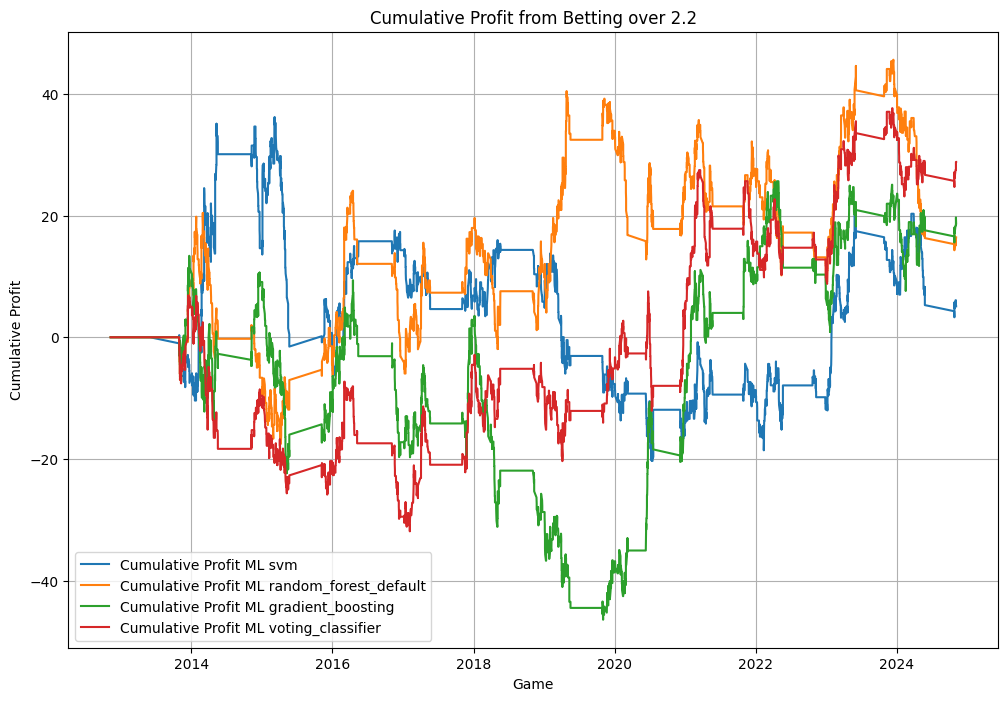

Home method (-66.56/1433): -0.0464
ML method with naive_bayes          --> (-111.55/1656): -0.0674
ML method with knn                  --> ( -44.48/1030): -0.0432
ML method with logistic_regression  --> ( -17.74/880): -0.0202
ML method with svm                  --> (   5.08/1088): 0.0047
ML method with random_forest_default --> (  16.41/1094): 0.015
ML method with random_forest        --> ( -54.27/1038): -0.0523
ML method with gradient_boosting    --> (  18.69/1214): 0.0154
ML method with ada_boost            --> ( -97.56/1238): -0.0788
ML method with mlp                  --> (-160.37/1554): -0.1032
ML method with voting_classifier    --> (   28.8/1014): 0.0284

Profit for voting_classifier: $28.8
Accuracy for voting_classifier: 0.54
Classification Report for voting_classifier:
              precision    recall  f1-score   support

           A       0.50      0.49      0.50       856
           D       0.33      0.09      0.14       764
           H       0.57      0.81      0.67     

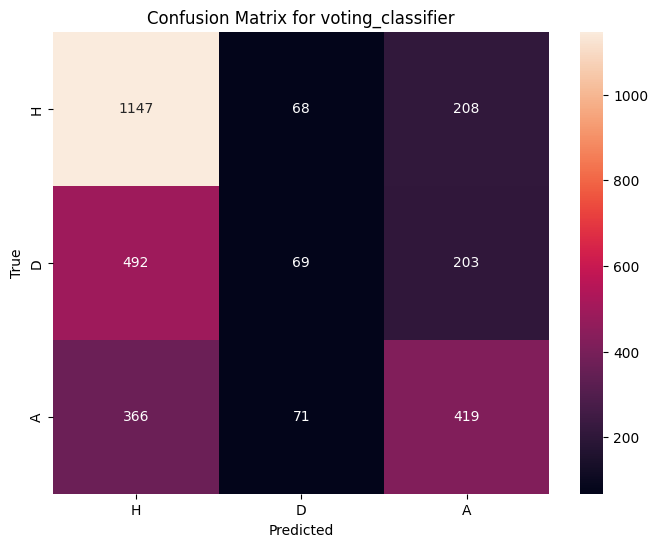

In [67]:
best_model_name = pf.get_simulation_results(matches, start_season, min_odds, plot_threshold, random_state, bankroll, strategy, default_value, default_bankroll_pct)

In [68]:
matches_filtered = matches[["date",  "season", "home_team", "away_team", "home_score", "away_score", "result", "home_odds", "draw_odds", "away_odds", f"PredictedRes_{best_model_name}", f'ProfitML_{best_model_name}', f'CumulativeProfitML_{best_model_name}']]
matches_filtered = matches_filtered[matches_filtered["season"] == 2024]
matches_filtered.tail(5)

# matches_filtered.to_csv("analysis_predictor.csv")

,date,season,home_team,away_team,home_score,away_score,result,home_odds,draw_odds,away_odds,PredictedRes_voting_classifier,ProfitML_voting_classifier,CumulativeProfitML_voting_classifier
3318,2024-11-02,2024,Osasuna,Valladolid,1,0,H,1.70,3.61,5.42,H,0.00,27.48
3319,2024-11-03,2024,Athletic Club,Betis,1,1,D,1.86,3.55,4.31,H,0.00,27.48
3320,2024-11-03,2024,Atlético Madrid,Las Palmas,2,0,H,1.33,5.22,9.01,H,0.00,27.48
3321,2024-11-03,2024,Sevilla,Real Sociedad,0,2,A,3.35,3.12,2.32,A,1.32,28.80
3322,2024-11-04,2024,Celta Vigo,Getafe,1,0,H,2.12,2.99,4.16,H,0.00,28.80


In [69]:
my_pipeline = trained_models[best_model_name]["pipeline"]
my_pipeline

data = {
    "pipeline": my_pipeline,
    "best_model_name": best_model_name,
    "min_games_played": min_games_played,
    "min_games_played_at": min_games_played_at,
    "min_odds": min_odds,
    "filtered_cols": filtered_cols,
    "strategy": strategy,
    "default_value": default_value,
    "default_bankroll_pct": default_bankroll_pct
}

# Save the pipeline
if save_pipeline:
    path = f"../dist/betting"
    
    save_file(path, data, league)